1. Leemos el archivo de business de Yelp

In [ ]:
import pandas as pd
import os
from unidecode import unidecode
#Abrir el archivo de business de Yelp
file_path = r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Yelp\business.pkl"
#Creamos el data frame
negocios_yelp = pd.read_pickle(file_path)
negocios_yelp = negocios_yelp.copy().reset_index(drop=True)
#Se eliminan las columnas repetidas
negocios_yelp= negocios_yelp.loc[:, ~negocios_yelp.columns.duplicated()]
#Cambiamos la columna a texto en minuscula para las busquedas
negocios_yelp["categories"] = negocios_yelp["categories"].str.lower()

2. Filtrar por NJ con county- lo realizamos con un segundo método para mostrar diversidad.

In [55]:
import geopandas as gpd
from shapely.geometry import Point

# Cargar todos los counties de EE.UU.
us_counties = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_county_500k.zip")

# Filtrar solo los de New Jersey (FIPS State Code = '34')
nj_counties = us_counties[us_counties['STATEFP'] == '34'].copy()

# Cambiar proyección a una métrica para que el buffer sea en metros (UTM Zone 18N cubre NJ)
nj_counties = nj_counties.to_crs(epsg=26918)

# Ampliar un 10% el tamaño de los polígonos con buffer
nj_counties["geometry"] = nj_counties.geometry.buffer(nj_counties.geometry.area.mean()**0.5 * 0.10)

# Regresar a WGS84 para empatar con los puntos (EPSG:4326)
nj_counties = nj_counties.to_crs(epsg=4326)

# Crear geometrías para restaurantes
geometry = [Point(xy) for xy in zip(negocios_yelp["longitude"], negocios_yelp["latitude"])]
gdf_restaurantes = gpd.GeoDataFrame(negocios_yelp, geometry=geometry, crs="EPSG:4326")

# Cruce espacial con los counties expandidos
negocios_con_county = gpd.sjoin(
    gdf_restaurantes,
    nj_counties[["NAME", "geometry"]],
    how="inner",
    predicate="within"
)

# Renombrar columna
restaurantes_con_county = negocios_con_county.rename(columns={"NAME": "County"})

print(f"Número de negocios dentro del área expandida 10% de NJ es: {len(restaurantes_con_county)}")


Número de negocios dentro del área expandida 10% de NJ es: 21915


2. Filtramos por restaurantes

In [57]:
def contains_restaurant_string(cat_string):
    if not cat_string or not isinstance(cat_string, str):
        return False
    return "restaurant" in cat_string.lower()



yelp_restaurantes = restaurantes_con_county[
    restaurantes_con_county["categories"].apply(contains_restaurant_string)
]

print(f"Se encontraron {len(yelp_restaurantes)} restaurantes en NJ")


Se encontraron 8436 restaurantes en NJ


3. Se genera la categorizacion de los restaurantes

In [58]:
#Mapeo de la categorización-creamos una columna nueva llamada category group.

category_mapping={
#FastFood
"hamburger":"FastFood",
"burger":"FastFood",
"hot dog":"FastFood",
"chicken wings":"FastFood",
"sandwich":"FastFood",
"cheese steak":"FastFood",
"fast food":"FastFood",

#PizzaandPasta
"pizza":"PizzaandPasta",
"italian":"PizzaandPasta",

#AsianCuisine
"chinese":"AsianCuisine",
"japanese":"AsianCuisine",
"sushi":"AsianCuisine",
"ramen":"AsianCuisine",
"thai":"AsianCuisine",
"vietnamese":"AsianCuisine",
"asian":"AsianCuisine",
"korean":"AsianCuisine",
"dimsum":"AsianCuisine",
"noodle":"AsianCuisine",

#Latin&Mexican
"mexican":"Latin&Mexican",
"salvadoran":"Latin&Mexican",
"guatemalan":"Latin&Mexican",
"latin":"Latin&Mexican",
"taco":"Latin&Mexican",
"peruvian":"Latin&Mexican",
"caribbean":"Latin&Mexican",
"puerto Rican":"Latin&Mexican",
"tex-mex":"Latin&Mexican",

#Healthy&SpecialtyDiets
"vegan":"Healthy&SpecialtyDiets",
"vegetarian":"Healthy&SpecialtyDiets",
"health":"Healthy&SpecialtyDiets",
"gluten-free":"Healthy&SpecialtyDiets",
"kosher":"Healthy&SpecialtyDiets",
"organic":"Healthy&SpecialtyDiets",
"salad":"Healthy&SpecialtyDiets",

#Indian&MiddleEastern
"indian":"Indian&MiddleEastern",
"pakistani":"Indian&MiddleEastern",
"middleEastern":"Indian&MiddleEastern",
"mediterranean":"Indian&MiddleEastern",
"shawarma":"Indian&MiddleEastern",
"falafel":"Indian&MiddleEastern",
"halal":"Indian&MiddleEastern",

#European&Continental
"spanish":"European&Continental",
"greek":"European&Continental",
"german":"European&Continental",
"irish":"European&Continental",
"polish":"European&Continental",
"portuguese":"European&Continental",

#Cafés&Bakeries
"coffee":"Cafés&Bakeries",
"bakery":"Cafés&Bakeries",
"bagel":"Cafés&Bakeries",
"donut":"Cafés&Bakeries",
"dessert":"Cafés&Bakeries",
"cakeshop":"Cafés&Bakeries",
"pretzel":"Cafés&Bakeries",

#Bars&Pubs
"bar":"Bars&Pubs",
"pub":"Bars&Pubs",
"winebar":"Bars&Pubs",
"karaoke":"Bars&Pubs",
"sports":"Bars&Pubs",
}


In [59]:
#Función para aplicar el mapeo
def map_category_string(cat_string):
    if not isinstance(cat_string, str):
        return None

    # Convertir a lista de categorías limpias
    categories = [cat.strip() for cat in cat_string.split(',')]

    # Buscar la primera categoría que aparezca en el diccionario
    for cat in categories:
        if cat in category_mapping:
            return category_mapping[cat]

    return "Other"  # o None si prefieres no asignar


# Aplicar la función para mapear a categoría general
yelp_restaurantes["category"] = yelp_restaurantes["categories"].apply(map_category_string)

# Crear una copia del DataFrame con la nueva columna
yelp_categorias = yelp_restaurantes.copy()

# Reiniciar el índice
yelp_categorias.reset_index(drop=True, inplace=True)


c:\Users\param\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


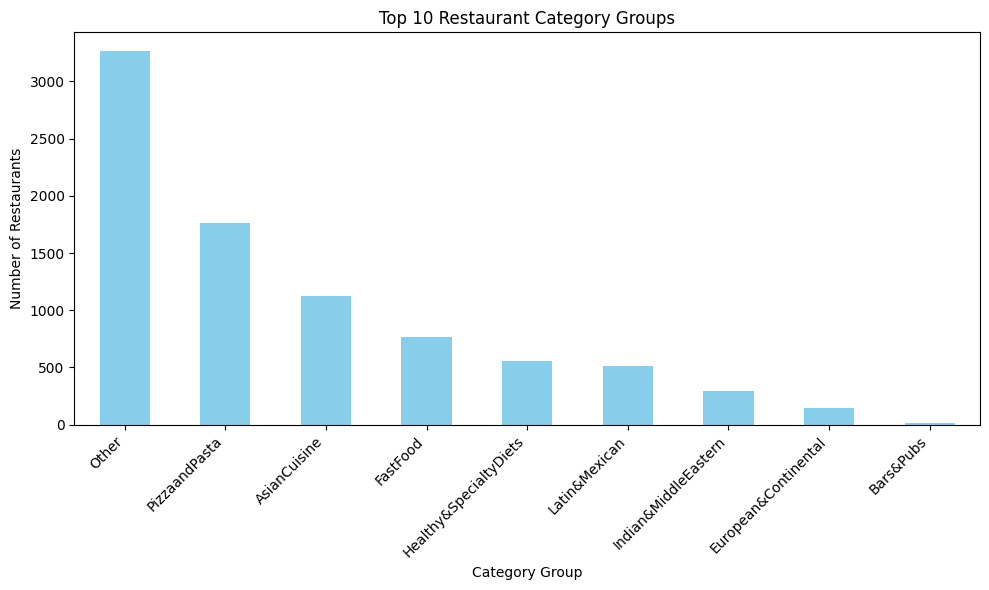

In [60]:
# Seleccionamos el top 5
import matplotlib.pyplot as plt

# Conteo de la frecuencia de cada grupo
group_counts = yelp_categorias['category'].value_counts().nlargest(10)

# Plot
plt.figure(figsize=(10, 6))
group_counts.plot(kind='bar', color='skyblue')
plt.title('Top 10 Restaurant Category Groups')
plt.xlabel('Category Group')
plt.ylabel('Number of Restaurants')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [61]:
categorias_a_eliminar = [
    "Other",
    "European&Continental",
    "Indian&MiddleEastern",
    "Bars&Pubs"
]


yelp_categorias = yelp_categorias[
    ~yelp_categorias["category"].isin(categorias_a_eliminar)
]


print(f"Quedan {len(yelp_categorias)} restaurantes después de eliminar las categorías no deseadas.")
print(yelp_categorias["category"].value_counts())


Quedan 4719 restaurantes después de eliminar las categorías no deseadas.
category
PizzaandPasta             1762
AsianCuisine              1125
FastFood                   764
Healthy&SpecialtyDiets     555
Latin&Mexican              513
Name: count, dtype: int64


4. Agregamos las variables socioeconómicas de CENSUS.

In [63]:
#Abrimos el archivo de CENSUS que tiene variables socio-economicas y que tiene la variable County.
ingresos_nj=pd.read_csv(r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Census-Ingresos NJ.csv")
#Quitamos los problemas de tildes, etc para ambos data frames-
ingresos_nj['County'] = ingresos_nj['County'].apply(lambda x: unidecode(x).upper())

yelp_categorias['County'] = yelp_categorias['County'].apply(lambda x: unidecode(x).upper())

# Step 2: Agrupamos por la media de County de las variables que nos interesa
ingresos_grouped = ingresos_nj.groupby('County')[[
    'MedianHH_Income',
    'Median_Home_Value',
    'Median_RE_Taxes'
]].mean().reset_index()

# Step 3: Juntamos ambas tablas
yelp_census = pd.merge(yelp_categorias, ingresos_grouped, on='County', how='left')

In [64]:
#Se eliminan las columnas que no se usarán para el analisis.
#Price- tiene muchos nulos y no sirve. Nuestro analisis es por County
yelp_census.drop(columns=["name","address","city","state","postal_code",'latitude','longitude',"categories","geometry","index_right","hours"],inplace=True)
print(f"Los negocios que son para nuestro análisis son {len(yelp_census)}")

Los negocios que son para nuestro análisis son 4719


5. Vamos a juntar el dataframe de negocios con el de reviews de Yelp

In [65]:
import json
import pandas as pd

# Crear un conjunto para búsqueda rápida de business_ids
business_ids = set(yelp_census["business_id"].unique())

# Lista para guardar reviews relevantes
matched_reviews = []

# Ruta del archivo JSON
json_path = r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Yelp\review.json"

# Leer línea por línea
with open(json_path, 'r', encoding='utf-8') as f:
    for line in f:
        try:
            review = json.loads(line)
            if review.get("business_id") in business_ids:
                matched_reviews.append(review)
        except json.JSONDecodeError:
            continue  # línea corrupta

# Convertir a DataFrame
yelp_reviews = pd.DataFrame(matched_reviews)
# Unir con yelp_merged
yelp_negocios_reviews = pd.merge(yelp_reviews, yelp_census, on="business_id", how="left")

# Ver resultado
print(f"Se encontraron {len(yelp_negocios_reviews)} reviews correspondientes a negocios en yelp_census.")

Se encontraron 400315 reviews correspondientes a negocios en yelp_census.


6. Ahora agreguemos el usuario al yelp_reviews

In [66]:
import pyarrow.parquet as pq
import pandas as pd

# Cargar los user_id únicos como conjunto para búsqueda rápida
user_ids = set(yelp_negocios_reviews["user_id"].unique())

# Ruta al archivo parquet grande
parquet_path = r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\user.parquet"

# Crear objeto Parquet
parquet_file = pq.ParquetFile(parquet_path)

# Lista para guardar los resultados
filtered_users = []

# Leer en batches
for batch in parquet_file.iter_batches(batch_size=100_000):
    batch_df = batch.to_pandas()
    filtered = batch_df[batch_df["user_id"].isin(user_ids)]
    filtered_users.append(filtered)

# Concatenar todos los resultados
users_df = pd.concat(filtered_users, ignore_index=True)

# Unir con yelp_merged
yelp_usuarios_reviews = pd.merge(yelp_negocios_reviews, users_df, on="user_id", how="left")

print(f"Se encontraron {len(yelp_usuarios_reviews)} que corresponde a los reviews de usuarios")


Se encontraron 577644 que corresponde a los reviews de usuarios


In [67]:
# Definir la ruta destino
ruta_destino = r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\datos_yelp_completo.parquet"

# Crear carpeta
os.makedirs(os.path.dirname(ruta_destino), exist_ok=True)

#Guardar en parquet
try:
    yelp_usuarios_reviews.to_parquet(ruta_destino, engine="pyarrow", compression="snappy")
    print(f"Archivo se guardo exitosamente: {ruta_destino}")
except Exception as e:
    print(f"Error para guardar archivo: {e}")

Archivo se guardo exitosamente: C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\datos_yelp_completo.parquet


7. Ahora agregamos los "tips".

In [15]:
import json
import pandas as pd

# Crear un conjunto para búsqueda rápida de business_ids
business_ids = set(yelp_usuarios_reviews["business_id"].unique())

# Lista para guardar reviews relevantes
matched_reviews = []

# Ruta del archivo JSON
json_path = r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\Yelp\tip.json"

# Leer línea por línea
with open(json_path, 'r', encoding='utf-8') as f:
    for line in f:
        try:
            review = json.loads(line)
            if review.get("business_id") in business_ids:
                matched_reviews.append(review)
        except json.JSONDecodeError:
            continue  # línea corrupta

# Convertir a DataFrame
tips_df = pd.DataFrame(matched_reviews)

# Unir con yelp_census si quieres los datos completos del negocio
yelp_completo = pd.merge(yelp_usuarios_reviews,tips_df, on="business_id", how="left")

# Ver resultado
print(f"Se encontraron {len(yelp_completo)} reviews correspondientes a negocios en yelp_census.")

MemoryError: Unable to allocate 3.47 GiB for an array with shape (11, 42338954) and data type object

In [73]:
yelp_usuarios_reviews.head(2)

,review_id,user_id,business_id,stars_x,useful_x,funny_x,cool_x,text,date,stars_y,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31,4.0,...,0,0,0,0,1,0,0,0,0,0
1,8JFGBuHMoiNDyfcxuWNtrA,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4.0,0,0,0,Good food--loved the gnocchi with marinara\nth...,2009-10-14 19:57:14,3.5,...,0,0,1,0,3,2,1,1,0,0
